In [1]:
import csv
import cv2
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# show first 5 driving data
column_names = ['center', 'left', 'right',
                'steering', 'throttle', 'brake', 'speed']
data_df = pd.read_csv('./data/driving_log.csv',names=column_names)
data_df.iloc[:5]

,center,left,right,steering,throttle,brake,speed
0,/Applications/python/carnd/CarND-Behavioral-Cl...,/Applications/python/carnd/CarND-Behavioral-C...,/Applications/python/carnd/CarND-Behavioral-C...,0.0,0.0,0,0.000081
1,/Applications/python/carnd/CarND-Behavioral-Cl...,/Applications/python/carnd/CarND-Behavioral-C...,/Applications/python/carnd/CarND-Behavioral-C...,0.0,0.0,0,0.000078
2,/Applications/python/carnd/CarND-Behavioral-Cl...,/Applications/python/carnd/CarND-Behavioral-C...,/Applications/python/carnd/CarND-Behavioral-C...,0.0,0.0,0,0.000079
3,/Applications/python/carnd/CarND-Behavioral-Cl...,/Applications/python/carnd/CarND-Behavioral-C...,/Applications/python/carnd/CarND-Behavioral-C...,0.0,0.0,0,0.000079
4,/Applications/python/carnd/CarND-Behavioral-Cl...,/Applications/python/carnd/CarND-Behavioral-C...,/Applications/python/carnd/CarND-Behavioral-C...,0.0,0.0,0,0.000079


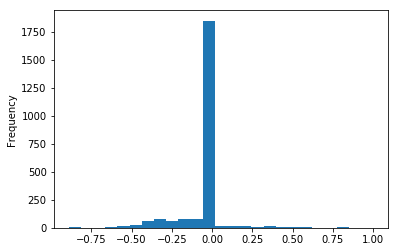

In [3]:
data_df['steering'].plot.hist(bins=25)

In [4]:
data_df['steering'].describe()

count    2340.000000
mean       -0.035303
std         0.148239
min        -0.889926
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

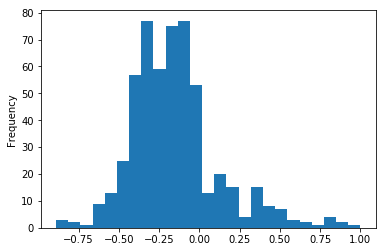

In [5]:
data_df.query('steering != 0')['steering'].plot.hist(bins=25)

In [6]:
lines = data_df.values

In [7]:
images = []
measurements = []
#for each driving data
for line in lines:
    steering_center = float(line[3])
    # create adjusted steering measurements for the side camera images
    correction = 0.6 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = "./data/IMG/" # fill in the path to your training IMG directory
    img_center = cv2.imread(path + line[0].split('/')[-1])
    img_left = cv2.imread(path + line[1].split('/')[-1])
    img_right = cv2.imread(path + line[2].split('/')[-1])

    # add images and angles to data set
    images.extend([img_center, img_left, img_right])
    measurements.extend([steering_center, steering_left, steering_right])
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = './data/IMG/'+filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3]) 
    measurements.append(measurement)


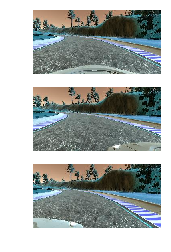

In [8]:
fig = plt.figure()
# Center Image
ax1 = fig.add_subplot(3,1,1)
#ax1.title("Center Image")
ax1.axis('off')
ax1.imshow(images[0])

# Left Image
ax2 = fig.add_subplot(3,1,2)
#ax2.title("Left Image")
ax2.axis('off')
ax2.imshow(images[1])

# Right Image
ax3 = fig.add_subplot(3,1,3)
#ax3.title("Right Image")
ax3.axis('off')
ax3.imshow(images[2])

In [9]:
# help with left turn bias
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement * -1.0)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
print(X_train.shape)

(18720, 160, 320, 3)


## Model Architecture and training

### 1. Appropriate Model Architecture
My initial Approach was to use [Lenet Architecture](http://yann.lecun.com/exdb/lenet/), but geting the car to remain in the road was difficult. Then i decided to try the [Nvidia Autonomous Car Model](https://devblogs.nvidia.com/deep-learning-self-driving-cars/). This proved better than the LeNet Architecture.

### 2. Reduce Overfitting
To reduce Overfitting, I decided to use a dropout of 0.5 on every layer of the Convolution Network,
Also keeping training epochs low: 3 epochs.

In addition, my driving data is split into training 70% and validation 30%. This can be seen as part of the code

### 3. Parameter tuning
I used an Adam Optimizer, so there was no need to tune learning rate

### 4. Appropriate training data
Training data was gotten by driving round the track 3 times. The simulator provides three different images: center, left and right. Each image is fed into the model to train

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D,Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Nvidia's Autonomous Vehicle Team Training Network 
model = Sequential()
# Normalization
model.add(Lambda(lambda x: x/ 255.0 - 0.5, input_shape=(160,320,3)))
# Crop the image to show only roads, remove noise from landscape
model.add(Cropping2D(cropping=((70,25), (0,0))))
# 5x5 Convolutional layer
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.5))
# 5x5 Convolutional layer
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.5))
# 5x5 Convolutional layer
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Dropout(0.5))
# 3x3 Convolutional layer
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Dropout(0.5))
# 3x3 Convolutional layer
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
# Dropout Layer
# Fully connected Layer
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
# Fully connected Layer
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
# Fully connected Layer
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, epochs=5)
#history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2)
model.save('model.h5')

# The model summary is printed here
print(model.summary())

/Users/judedike/miniconda3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
print(history_object.history.keys())
%matplotlib inline

### Here I show the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()